In [39]:
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import utils
import itertools
import theano
from theano import tensor as tt

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', fontsize=20)
pl.rc('lines', linewidth=4)

In [209]:
def apply_inverse(kernel, diag, t, x):
    m = kernel.Q.shape.eval()[0]
    diag = diag * np.ones((m, len(t)))
    gp = xo.gp.GP(kernel=kernel, diag=diag, x=t, J=2*m)
    return gp.apply_inverse_vector(x).eval()

def apply_inverse_direct(kernel, diag, t, x):
    m = kernel.Q.shape.eval()[0]
    ar, cr, ac, bc, cc, dc = kernel.get_coefficients()
    ar, cr, ac, bc, cc, dc = ar.eval(), cr.eval(), ac.eval(), bc.eval(), cc.eval(), dc.eval()
    def K(tau):
        realterms = np.sum([a*np.exp(-c*tau) + 
                            b*np.exp(-c*tau) 
                            for (a, c) in zip(ar, cr)])
        compterms = np.sum([a*np.exp(-c*tau)*np.cos(d*tau) + 
                            b*np.exp(-c*tau)*np.sin(d*tau) 
                            for (a, b, c, d) in zip(ac, bc, cc, dc)])
        return realterms + compterms
    covariance = np.zeros((len(t), len(t)))
    for i, ti in enumerate(t):
        for j, tj in enumerate(t):
            tau = np.abs(ti - tj)
            covariance[i, j] = K(tau)
    covariance = np.kron(covariance, kernel.Q.eval())
    covariance = np.diag(diag*np.ones(m*len(t))) + covariance
    return np.linalg.inv(covariance).dot(x)

def fullfisher_direct(t, tparams, gpparams, a=[1]):
    a = np.array(a)
    log_s, log_w0, log_q, diag = gpparams
    Q = a[:, None]*a[None, :]
    
    # define the gp 
    term = xo.gp.terms.SHOTerm(log_S0=log_s, log_w0=log_w0, log_Q=log_q)
    kernel = xo.gp.terms.KroneckerTerm(term, Q)
    
    # compute the trapezoidal transit derivatives
    dtrans = utils.transit(t, *tparams)
        
    # compute the Fisher matrix 
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        x = np.tile(x, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(x)).T
        y = np.tile(y, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(y)).T
        fish[i, j] = x.T.dot(apply_inverse_direct(kernel, diag, t, y))
    return fish

def fisher_direct(t, tparams, gpparams, a=[1]):
    fish = fullfisher_direct(t, tparams, gpparams, a=a)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

In [412]:
# alpha_N / alpha_1 
x = np.linspace(1, 10, 10)

# variance of the white noise 
diag = np.exp(-5)

# variance of the correlated component 
alpha = np.exp(-10)

# smallest and largest wavelength scale factors 
alpha1 = 1 / (1 + x)
alpha2 = 1 / (1 + 1/x)

# compute alpha vectors 
a = np.array([alpha1, alpha2]).T
a3 = [np.linspace(a1, a2, 3) for (a1, a2) in zip(alpha1, alpha2)]
a4 = [np.linspace(a1, a2, 4) for (a1, a2) in zip(alpha1, alpha2)]
a5 = [np.linspace(a1, a2, 5) for (a1, a2) in zip(alpha1, alpha2)]

#a = [a/np.sqrt(np.sum(a ** 2)) for a in a]
#a3 = [a/np.sqrt(np.sum(a ** 2)) for a in a3]
#a4 = [a/np.sqrt(np.sum(a ** 2)) for a in a4]
#a5 = [a/np.sqrt(np.sum(a ** 2)) for a in a5]

# parameters of the transit and correlated noise 
t = np.linspace(-3, 3, 100)
tparams = [0.0, 0.1, 1.0, 0.1]  # t0, r, d, tin
logw0 = 5.0
logq = -np.log(np.sqrt(2))

In [413]:
#fish1 = [fisher_white_noise_only(t, tparams, diag) for a in a]
fish2 = [fisher_direct(t, tparams, [np.log(alpha), logw0, logq, diag*2], a=a)[0] for a in a]
fish3 = [fisher_direct(t, tparams, [np.log(alpha), logw0, logq, diag*3], a=a)[0] for a in a3]
fish4 = [fisher_direct(t, tparams, [np.log(alpha), logw0, logq, diag*4], a=a)[0] for a in a4]
fish5 = [fisher_direct(t, tparams, [np.log(alpha), logw0, logq, diag*5], a=a)[0] for a in a5]

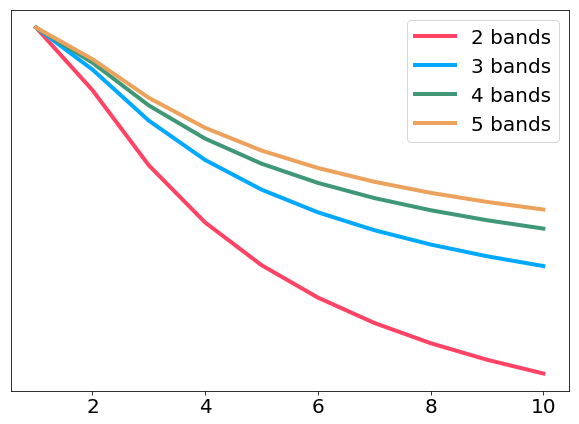

In [414]:
pl.figure(figsize=(10, 7))
pl.semilogy(x, np.array(fish2), '-', color=red, label="2 bands")
pl.semilogy(x, np.array(fish3), '-', color=blue, label="3 bands")
pl.semilogy(x, np.array(fish4), '-', color=green, label="4 bands")
pl.semilogy(x, np.array(fish5), '-', color=yellow, label="5 bands")
pl.legend()
pl.savefig("/Users/tgordon/Desktop/direct.pdf")

In [64]:
def sig_poly(N, sigma, alpha):
    gamma = alpha / sigma
    gamma2 = gamma ** 2
    num = 1 + np.sum(gamma2)
    denom1 = N * ( 1 + np.sum(gamma2))
    denom2 = np.sum(gamma) ** 2
    return num / (denom1 + denom2)

def sig_mono(N, sigma, alpha):
    gamma = alpha / sigma
    return ( 1 / N ) + (np.sum(gamma) / N) ** 2

In [422]:
def c29_over_c30(logsig, logs0):
    N = np.array([2, 10])
    sigma = np.exp(logsig)
    S0 = np.exp(logs0)
    alpha1 = 1
    alpha2 = 2
    alphan = np.array([np.linspace(alpha1, alpha2, n) for n in N])
    r = [sig_poly(n, sigma, S0*alphan) / sig_mono(n, sigma, S0*alphan) for (n, alphan) in zip(N, alphan)]
    return r[1] - r[0]

In [423]:
lsig = np.linspace(-10, 10, 50)
ls0 = np.linspace(-10, 10, 50)
c29c30 = np.zeros((len(lsig), len(ls0)))
for (i, ls) in enumerate(lsig):
    for (j, l0) in enumerate(ls0):
        #print(ls, l0)
        c29c30[len(lsig) - 1 - i, j] = c29_over_c30(ls, l0)

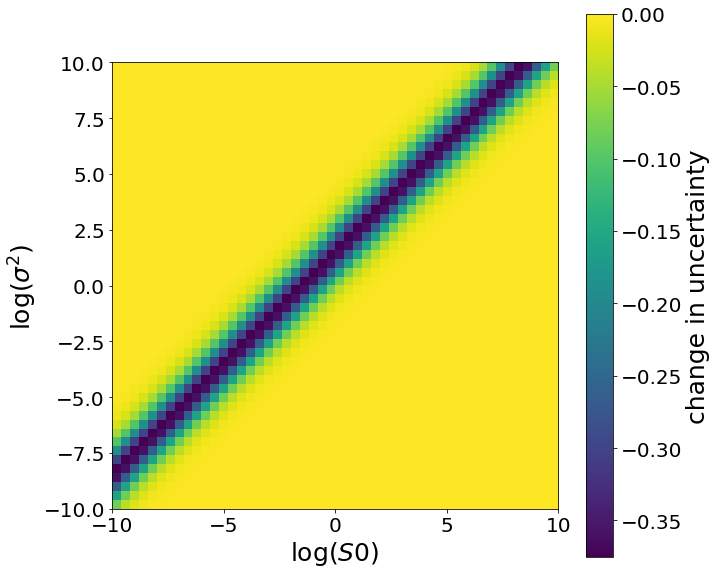

In [432]:
fig = pl.figure(figsize=(10, 10))
#pl.contour(np.sign(c29c30), origin='upper', extent=(ls0[0], ls0[-1], lsig[0], lsig[-1]), colors='k')
pl.imshow(c29c30, origin='upper', extent=(ls0[0], ls0[-1], lsig[0], lsig[-1]))
pl.xlabel(r"$\log(S0)$")
pl.ylabel(r"$\log(\sigma^2)$")
#pl.annotate("Uncertainty \ndecreases with N", xy=(0.2, 0.9), xycoords='axes fraction', fontsize=20)
#pl.annotate("Uncertainty \nincreases with N", xy=(0.4, 0.1), xycoords='axes fraction', fontsize=20)
cb = pl.colorbar()
cb.set_label("change in uncertainty")
pl.savefig('/Users/tgordon/Desktop/huh.pdf')

In [426]:
c29c30

array([[-4.44089210e-16, -4.44089210e-16, -1.11022302e-15, ...,
        -2.64526187e-01, -1.57765087e-01, -8.17060978e-02],
       [-4.44089210e-16, -1.11022302e-15, -1.77635684e-15, ...,
        -1.57765087e-01, -8.17060978e-02, -3.90243544e-02],
       [-1.11022302e-15, -1.77635684e-15, -4.10782519e-15, ...,
        -8.17060978e-02, -3.90243544e-02, -1.78830332e-02],
       ...,
       [-2.64526187e-01, -1.57765087e-01, -8.17060978e-02, ...,
        -1.04853633e-17, -4.63508151e-18, -2.04894956e-18],
       [-1.57765087e-01, -8.17060978e-02, -3.90243544e-02, ...,
        -4.63508151e-18, -2.04894956e-18, -9.05743363e-19],
       [-8.17060978e-02, -3.90243544e-02, -1.78830332e-02, ...,
        -2.04894956e-18, -9.05743363e-19, -4.00386156e-19]])